# Capstone Project - Smart Basket for Automatic Product Classification and Counting 


___


**Problem Statement:**

In supermarkets and grocery stores, the process of identifying and counting products often requires manual input, which can be slow and prone to errors. This inefficiency can lead to longer checkout times and inaccurate pricing, which negatively impacts both customer experience and store operations. Developing a "smart basket" that automatically recognizes products based on images can significantly speed up the shopping process.

**Context:**

As the retail industry increasingly moves towards automation and efficiency, there is a growing need for smart solutions that can streamline the shopping experience. A smart basket that uses image processing to identify and count products can reduce the need for manual scanning and entry, making the checkout process faster and more accurate. This project aims to bridge this gap by leveraging image processing techniques to develop a model capable of classifying and counting products in real-time.

**Data Sources:**

Primary Dataset: Fruits-360 dataset https://www.kaggle.com/moltean/fruits containing over 70,000 images of 120 types of fruits and vegetables. This dataset will be used to train and validate the image classification model.



<h2 style="color:red;">Preprocessing-Modeling is currently in coding mode</h2>


## 1 Data Loading

Download the necessary libraries for working with archives, file system and data analysis

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [213]:
%matplotlib inline

In [214]:
pip install --upgrade tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [215]:
import pickle

# Loading a global variable from a file
with open('df_train.pkl', 'rb') as f:
    my_global_df_train = pickle.load(f)

# Checking the content
my_global_df_train.head()


,label,image_path,brightness,image_size,processed_image
0,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,146.202051,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 4, 38, 25..."
1,apple_braeburn_1,../data/raw/fruits-360/fruits-360/fruits-360-o...,93.975101,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,pear_1,../data/raw/fruits-360/fruits-360/fruits-360-o...,148.050868,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
3,zucchini_1,../data/raw/fruits-360/fruits-360/fruits-360-o...,171.733518,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
4,apple_golden_2,../data/raw/fruits-360/fruits-360/fruits-360-o...,185.297155,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


In [216]:
# Loading a global variable from a file
with open('df_test.pkl', 'rb') as f:
    my_global_df_test = pickle.load(f)

# Проверка содержимого
my_global_df_test.head()

,label,image_path,brightness,image_size,processed_image
0,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,112.487951,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,108.764763,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,146.202051,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 4, 38, 25..."
3,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,134.131658,"(100, 100)","[[255, 255, 79, 0, 0, 167, 255, 255, 255, 255,..."
4,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,96.214535,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


In [217]:
df_train = my_global_df_train
df_test = my_global_df_test

In [218]:
# Step 1: Extracting image and label data
X_train = np.stack(df_train['processed_image'].values)
y_train = df_train['label'].values
X_test = np.stack(df_test['processed_image'].values)
y_test = df_test['label'].values

In [219]:
# Checking the data form
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (9341, 100, 100)
y_train: (9341,)
X_test: (3110, 100, 100)
y_test: (3110,)


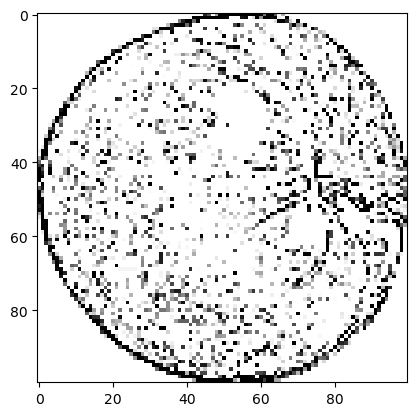

In [220]:
plt.imshow(X_train[250],cmap='gray')

In [221]:
y_train[250]

'apple_crimson_snow_1'

## Preprocessing the image data

In [222]:
image_height, image_width = 100, 100

# Data conversion
X_train = X_train.reshape(9341, image_height * image_width)
X_test = X_test.reshape(3110, image_height * image_width)

# Checking the data form
print(X_train.shape)
print(X_test.shape)


(9341, 10000)
(3110, 10000)


In [223]:
print(X_train[250])
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

[255 255 255 ... 255 255 255]


In [224]:
X_train /= 255.0
X_test /= 255.0
print(X_train[250])

[1. 1. 1. ... 1. 1. 1.]


In [225]:
# Get the unique values and their counts
unique_values, counts = np.unique(y_train, return_counts=True)

# Combine them into a dictionary to display
label_counts = dict(zip(unique_values, counts))

label_counts

{'apple_6': 472,
 'apple_braeburn_1': 480,
 'apple_crimson_snow_1': 477,
 'apple_golden_1': 462,
 'apple_golden_2': 462,
 'apple_golden_3': 474,
 'apple_granny_smith_1': 480,
 'apple_hit_1': 702,
 'apple_pink_lady_1': 469,
 'apple_red_1': 463,
 'apple_red_2': 477,
 'apple_red_3': 421,
 'apple_red_delicios_1': 450,
 'apple_red_yellow_1': 462,
 'apple_rotten_1': 478,
 'cabbage_white_1': 143,
 'carrot_1': 151,
 'cucumber_1': 150,
 'cucumber_3': 244,
 'eggplant_long_1': 240,
 'pear_1': 488,
 'pear_3': 216,
 'zucchini_1': 240,
 'zucchini_dark_1': 240}

In [226]:
# Checking the number of unique labels in the 'y_train'
unique_labels_count = len(np.unique(y_train))
unique_labels_count

24

In [227]:
# Get the unique values and their counts
unique_values, counts = np.unique(y_test, return_counts=True)

# Combine them into a dictionary to display
label_counts = dict(zip(unique_values, counts))

label_counts

{'apple_6': 157,
 'apple_braeburn_1': 160,
 'apple_crimson_snow_1': 159,
 'apple_golden_1': 154,
 'apple_golden_2': 154,
 'apple_golden_3': 158,
 'apple_granny_smith_1': 160,
 'apple_hit_1': 234,
 'apple_pink_lady_1': 156,
 'apple_red_1': 154,
 'apple_red_2': 159,
 'apple_red_3': 140,
 'apple_red_delicios_1': 150,
 'apple_red_yellow_1': 154,
 'apple_rotten_1': 159,
 'cabbage_white_1': 47,
 'carrot_1': 50,
 'cucumber_1': 50,
 'cucumber_3': 81,
 'eggplant_long_1': 80,
 'pear_1': 162,
 'pear_3': 72,
 'zucchini_1': 80,
 'zucchini_dark_1': 80}

In [228]:
# Checking the number of unique labels in the 'y_test'
unique_labels_count = len(np.unique(y_test))
unique_labels_count

24

In [229]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Step 1: Convert string labels to numerical labels
label_encoder = LabelEncoder()

# Fitting the label encoder and transforming the labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Step 2: Convert the numerical labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded, num_classes=24)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=24)

# Checking the shape of the one-hot encoded labels
print(y_train_one_hot.shape)
print(y_test_one_hot.shape)

(9341, 24)
(3110, 24)


## Build the model

In [231]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Creating a model
model = Sequential()

# Adding the first layer
model.add(Dense(512, activation='relu', input_shape=(image_height * image_width,)))
model.add(Dropout(0.3))  # Dropout для предотвращения переобучения

# Adding a second layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

# Output layer with softmax to classify 24 classes
model.add(Dense(24, activation='softmax'))

# Compiling the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Displaying the model structure
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │     5,120,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,395,480 (20.58 MB)

 Trainable params: 5,395,480 (20.58 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [232]:
history = model.fit(X_train, y_train_one_hot, epochs=20, validation_data=(X_test, y_test_one_hot))

Epoch 1/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0624 - loss: 4.1367 - val_accuracy: 0.1450 - val_loss: 2.7767
Epoch 2/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1038 - loss: 2.8753 - val_accuracy: 0.1132 - val_loss: 2.8199
Epoch 3/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1063 - loss: 2.8340 - val_accuracy: 0.1331 - val_loss: 2.6183
Epoch 4/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1203 - loss: 2.7835 - val_accuracy: 0.1598 - val_loss: 2.5296
Epoch 5/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1234 - loss: 2.7515 - val_accuracy: 0.1383 - val_loss: 2.5807
Epoch 6/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1355 - loss: 2.7146 - val_accuracy: 0.1675 - val_loss: 2.4786
Epoch 7/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1424 - loss: 2.6759 - val_accuracy: 0.1698 - val_loss: 2.4200
Epoch 8/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1339 - loss: 2.7149 - val_accu

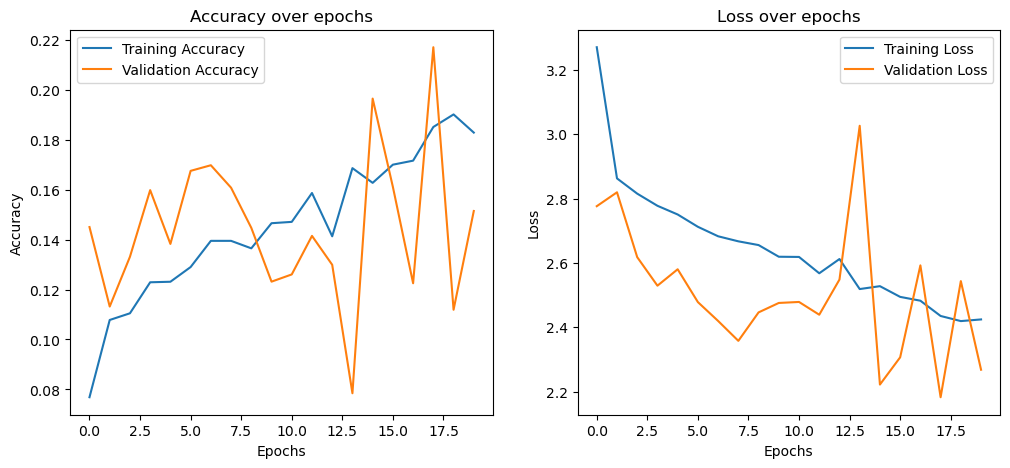

In [235]:
# Let's plot both accuracy and loss for training and validation datasets.

import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


## Evaluating the model

In [239]:
score = model.evaluate(X_test, y_test_one_hot)

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1571 - loss: 2.2917


# CNN